# Домашняя работа №6. Метод ближайших соседей

Цель работы: Обучить модель методом K-ближайших соседей.

### Работа с набором данных для задачи классификации (целевая переменная - класс объекта)

## Задание №1

#### Предварительная подготовка данных

Подготовить данные (если не выполнялось ранее, иначе использовать подготовленные данные):

* Заполнить пропуски в данных подходящими значениями (например, 0 для числовых значений, other для категориальных значений).
* Проверить датасет на дубликаты. Удалить при наличии.
* Закодировать категориальные значения. Например, создать новые булевые признаки (OneHotEncoder), или назначить число для каждого значения (LabelEncoder).
* Удалить столбцы с уникальными значениями, при наличии.
* К числовым признакам применить масштабирование со средним нулевым значением.
* Разделить на тренировочную и обучающую выборки.

## Задание №2

#### Обучение модели
* Обучите KNeighborsClassifier на подготовленных данных с количеством соседей равным 5.
* Построить график зависимости предсказаний от количества соседей.

## Задание №3

#### Настройка гиперпараметров модели
* С помощью инструмента Optuna подобрать оптимальные гиперпараметры (количество соседей, расстояние, алгоритмы: ball_tree, kd_tree, auto)
* Обучите модель с лучшими метриками.
* Вычислить метрики полученной модели (f1, recall, precision).
* Сделать вывод о качестве обученной модели.
* Получить предсказания на тестовой выборке

#Решение домашней работы №6

## Задание №1
Были выгружены тестовая и тренировочная выборка из обработанных данных датасэта 5-ого задания с помощью следующего кода:

In [36]:
import pandas as pd

# X_train_df = pd.DataFrame(X_train)
# X_test_df = pd.DataFrame(X_test)
# y_train_df = pd.DataFrame(y_train)
# y_test_df = pd.DataFrame(y_test)

# X_train_df.to_csv('X_train.csv', index=False)
# X_test_df.to_csv('X_test.csv', index=False)
# y_train_df.to_csv('y_train.csv', index=False)
# y_test_df.to_csv('y_test.csv', index=False)

In [37]:
X_train = pd.read_csv('/content/X_train.csv').values
X_test = pd.read_csv('/content/X_test.csv').values
y_train = pd.read_csv('/content/y_train.csv')['Survived'].values
y_test = pd.read_csv('/content/y_test.csv')['Survived'].values

##Задание №2

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [39]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
y_pred = knn.predict(X_test)

accuracy = knn.score(X_test, y_test)
print(f'Точность модели при k=5: {accuracy:.4f}')

Точность модели при k=5: 0.8045


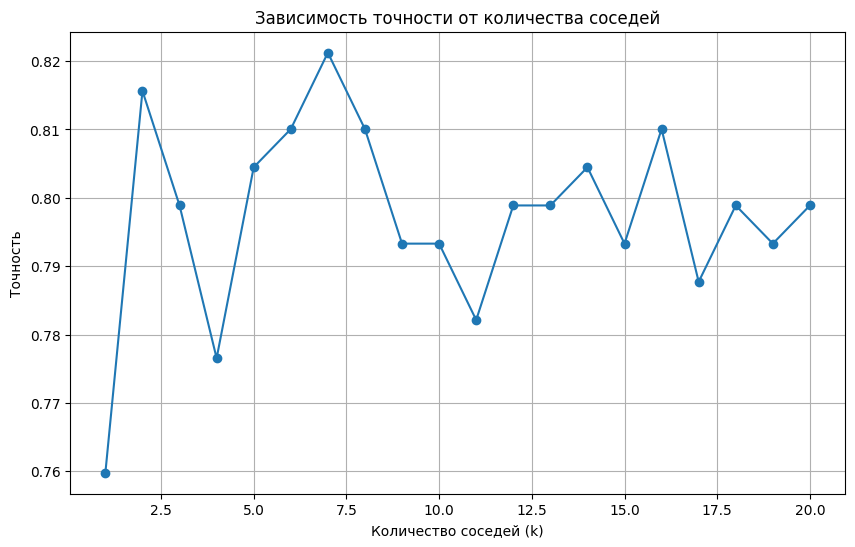

In [41]:
def plot_knn_accuracy(X_train, X_test, y_train, y_test):
    ks = range(1, 21)

    accuracies = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = knn.score(X_test, y_test)
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, accuracies, marker='o')
    plt.xlabel('Количество соседей (k)')
    plt.ylabel('Точность')
    plt.title('Зависимость точности от количества соседей')
    plt.grid(True)
    plt.show()

plot_knn_accuracy(X_train, X_test, y_train, y_test)

##Задание №3

In [42]:
pip install optuna

In [43]:
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from optuna.samplers import TPESampler
from optuna import create_study

In [44]:
search_space = {
    'n_neighbors': lambda _: int(_[0]),
    'weights': lambda _: _[1],
    'algorithm': lambda _: _[2]
}

In [45]:
def evaluate_model(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'auto'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    return scores.mean()

In [46]:
study = create_study(sampler=TPESampler(seed=42), direction='maximize')
study.optimize(evaluate_model, n_trials=50)

[I 2024-12-25 19:53:36,435] A new study created in memory with name: no-name-43e842a6-2185-4cca-a68c-52497e6a73fd
[I 2024-12-25 19:53:36,519] Trial 0 finished with value: 0.6955210843032792 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.6955210843032792.
[I 2024-12-25 19:53:36,587] Trial 1 finished with value: 0.5582254032289468 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.6955210843032792.
[I 2024-12-25 19:53:36,675] Trial 2 finished with value: 0.6870344674421204 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 0 with value: 0.6955210843032792.
[I 2024-12-25 19:53:36,713] Trial 3 finished with value: 0.7091243470519173 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'auto'}. Best is trial 3 with value: 0.7091243470519173.
[I 2024-12-25 19:53:36,788] Trial 4 finished with value: 0.694447

In [47]:
best_params = study.best_params
print("Лучшие параметры:")
for key, value in best_params.items():
    print(f"{key}: {value}")

Лучшие параметры:
n_neighbors: 27
weights: distance
algorithm: ball_tree


In [48]:
model = KNeighborsClassifier(**best_params)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=27, weights='distance')

In [49]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\nМетрики модели:")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")


Метрики модели:
F1 Score: 0.7172
Recall: 0.7027
Precision: 0.7324


In [52]:
if f1 >= 0.91:
    print("\nМодель обладает высоким качеством.")
elif f1 >= 0.79:
    print("\nМодель обладает хорошим качеством.")
else:
    print("\nКачество модели требует улучшения.")


Качество модели требует улучшения.


In [53]:
predictions = model.predict(X_test)
print("\nПредсказания на тестовой выборке:")
print(predictions)


Предсказания на тестовой выборке:
[0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1
 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 1]
